In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 4114253737


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 1000
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)
print("Model loaded")

Model loaded


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("The dragon flew", 50, 0.7))
test_regular_sampler()

The dragon flew away. She did not need to be afraid. The dragon did not need to be afraid of her. She had been frightened of the dragon. She had been frightened of the dragon. She had been frightened of the dragon. She had been frightened of the dragon. She had been frightened of the dragon. She had been frightened of the dragon.

She could not stand the sight of the dragon. It was a huge, huge dragon. It had a huge mouth. It was huge. It was huge. It was huge. She was scared of the dragon.

She was frightened of the dragon. She had


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

Dataset demo snapshot:
<d><scn>facin2<msg>An "Not exactly, but I have a way with words. My tongue is quite skilled, or so I hear."<|endoftext|><d><scn>black<msg>An "Right? It comes in handy."<|endoftext|><p><msg>c "Alright."<|endoftext|><d><scn>cafe<msg>An "Just get it over with already."<|endoftext|><d><scn>facin2<msg>An "Neither, I think my break should start right about... now."<|endoftext|><d><scn>black<msg>Ry "
Maybe I should stop being such a sourpuss then."<|endoftext|><p><msg>c "Let's go, then."<|endoftext|><d><scn>o2<msg>Br "And now we can finally play spin the bottle."<|endoftext|><d><scn>pad<msg>Br "Just as you do, occasionally, I bet."<|endoftext|><p><msg>c "Let's say if I win, I'll get to go on a real date with you."<|endoftext|><p><msg>c "Not at all."<|endoftext|><d><scn>beach<msg>Ad "Hey,
[0] set freeze_part_layers: True (freezing 155 out of 160 layers.)


Step,Training Loss
1050,2.087300
2100,1.658600
3150,1.497800
4200,1.382300
5250,1.297200
6300,1.236300
7350,1.179100
8400,1.140100
9450,1.101900
10500,1.073900


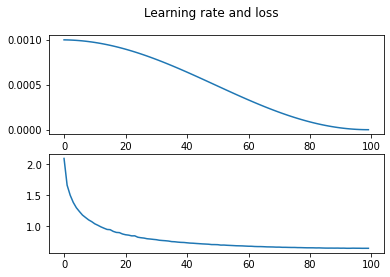

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [9]:
model.eval()
test_regular_sampler()

The dragon flew over the water, claws extended, claws on the ground with feet. As she started to land, she was struck by a fish a few times before it landed on the ground with a fish a few times before it landed on the water a second, and her mouth opened."<d><scn>black<msg>n "She was struck by a different one, but not the least. When it landed on the ground, she opened her eyes."<d><scn>black<msg>n "I tried to speak to her, but I was so lost in thought that I didn't think I had


In [10]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: remyapt<msg>Ry "You said you were thinking about something."<d><scn>remyapt<msg>Ry "Oh, I believed you for a moment. Guess I can show you some of theiqueness contained within."<d><scn>remyapt<msg>Ry "I can show you someiqueness contained within..."<d><scn>remyapt<msg>m "He said


Prompt: What do you think of Lorem?
Reply: o2<msg>Ad "I'm not sure, exactly, but I think I'd like to check that out as well."<p><msg>c "I'm not sure, exactly, but I think I'd like to check out some of Lorem's personality."<d><scn>o2<msg>Ad "I'm not sure, exactly, but I think I would like


Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "It's a locked door."<d><scn>o2<msg>Ad "Then what are you doing here?"<p><msg>c "I was just trying to be quiet. It's a locked door."<d><scn>o2<msg>Ad "Then what are you doing here?"<p><msg>c "I was just trying


Prompt: What will we do here?
Reply: facin2<msg>An "I sat down on a chair in my office."<d><scn>facin2<msg>An "I sat down on a chai

# Sampling test

This is gonna be interesting!

In [11]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: remyapt<msg>Ry "You can't be serious."<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: o2<msg>Ad "It's fine, [player_name]. I'll just watch from here. Maybe you can think of something you like."<p><msg>c "That's fine, I'll just watch from here. Maybe you can think of something you like."<p><msg>c "You don't have to."<d><scn>o2<msg>

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "No, it's all so petty, [player_name]."<d><scn>o2<msg>Ad "Oh my god, [player_name], what is that?"<p><msg>c "That's what [player_name] is. It's a human. Not a dragon, either."<|endoftext|>

[Test 1] -> Prompt: What will we do here?
Reply: loremapt<msg>I sat down on the table a little away from him and, in a silence, I was unlocked. I was unlocked, though, but I was unlocked, right out of the corner of his eye, which was right all the time, right in the middle of his lid."<d><scn>loremapt<msg>Lo "I sat down on the table a little a

In [12]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined